<center> <img src = https://bronirovanie-otelej-onlajn.ru/image/data/booking/booking%20(1).jpg alt="drawing" style="width:400px;">

# <center> Проект: Прогнозирование рейтинга отеля на Booking.com

In [ ]:
# базовые библиотеки
import numpy as np 
import pandas as pd 

# кодирование
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder

# визуализация
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# оценка значимости признаков
from sklearn.feature_selection import f_classif, chi2

# инструмент для разделения датасета
from sklearn.model_selection import train_test_split

# создание, обучение, оценка качества модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


# Загрузка данных

In [2]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы!

RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов:

!pip freeze > requirements.txt

In [4]:
# Подгрузим данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения 
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # submission

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [11]:
# Для корректной обработки признаков объединяем train и test в один датасет

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, поэтому пока просто заполняем нулями

data = pd.concat([df_train, df_test]).reset_index(drop=True)

# Исследование структуры данных

Выведем датасет на экран:

In [12]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,1


### Данные содержат следующие признаки:  

`hotel_address ` - адрес отеля; 

`review_date` - дата, когда рецензент разместил соответствующий отзыв; 

`average_score` - средний балл отеля, рассчитанный на основе последнего комментария за последний год;  

`hotel_name` - название отеля;  

`reviewer_nationality` - национальность рецензента;  

`negative_review` - отрицательный отзыв, который рецензент дал отелю;  

`review_total_negative_word_counts` - общее количество слов в отрицательном отзыв;  

`positive_review` - положительный отзыв, который рецензент дал отелю;  

`review_total_positive_word_counts` - общее количество слов в положительном отзыве;  

`reviewer_score` - оценка, которую рецензент поставил отелю на основе своего опыта;  

`total_number_of_reviews_reviewer_has_given` - количество отзывов, которые рецензенты дали в прошлом;  

`total_number_of_reviews` - общее количество действительных отзывов об отеле;  

`tags` - теги, которые рецензент дал отелю;  

`days_since_review` - продолжительность между датой проверки и датой очистки;  

`additional_number_of_scoring` - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки;  

`lat` - широта отеля;  

`lng` - долгота отеля

Посмотрим на представленные типы данных:

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

В последних двух столбцах с координатами lat и lng обнаружены пропуски.  

Выведем на экран описательную статистику по столбцам датафрейма:

In [14]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,sample
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,6.297672,49.442439,2.823803,0.749999
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.902295,3.466325,4.579425,0.433014
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,41.328376,-0.369758,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.625000,48.214662,-0.143372,0.250000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,7.900000,51.499981,0.010607,1.000000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.600000,51.516288,4.834443,1.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233,1.000000


Теперь по строковым признакам:

In [15]:
data.describe(include=['object'])

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,515738,515738,515738,515738,515738,515738,515738,515738
unique,1493,731,1492,227,330011,412601,55242,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,4789,2585,4789,245246,127890,35946,5101,2585


На первый взгляд, какие либо аномальные значения не выделяются из всего датафрейма.

Изучим распределение в представленных данных:

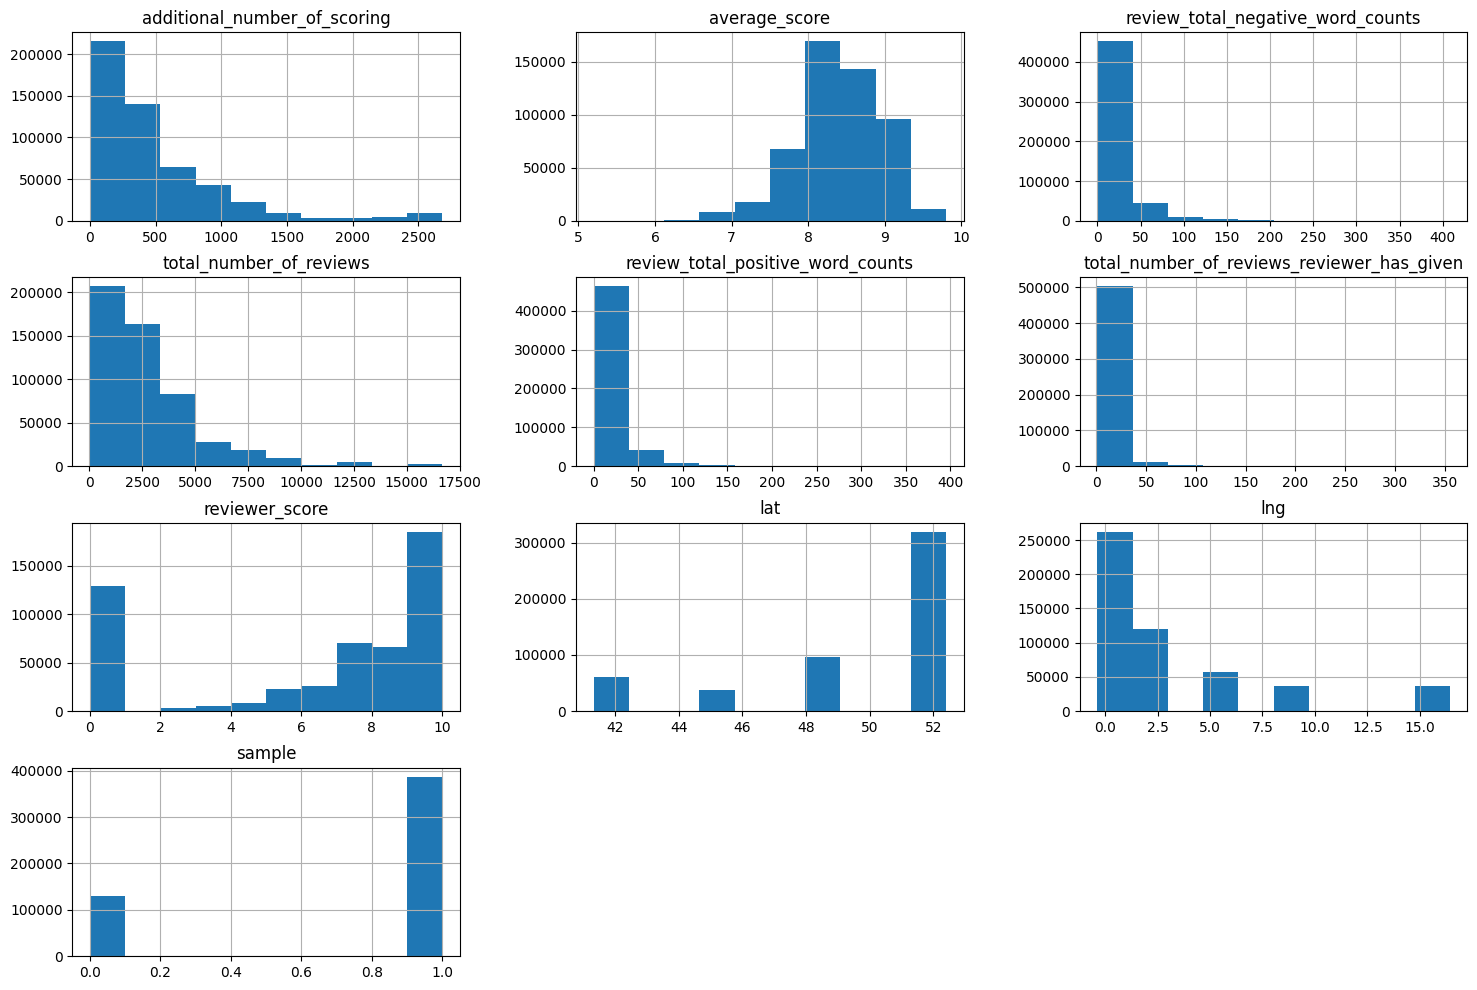

In [16]:
data.hist(figsize=(18,12));

Ни один из признаков внешне не напоминает распределение Гаусса. **Распределение некоторых признаков похоже на логнормальное**.

# Преобразование данных

Начнем наши манипуляции с данными с признака адреса отеля. Данный признак содержит в себе множество информации, такой как:  
- страна
- город
- район
- почтовый индекс
- название улицы
- номер здания

In [17]:
data['hotel_address'].value_counts()

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              4789
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     4256
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     4169
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    3578
7 Pepys Street City of London London EC3N 4AF United Kingdom                      3212
                                                                                  ... 
Via Palmanova 153 20132 Milan Italy                                                 12
21 rue Lavoisier 8th arr 75008 Paris France                                         12
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                             10
13 Rue Fran ois Ory 92120 Paris France                                              10
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              8
Name: hotel_address, Length: 1493, dtype: i

Всю эту информацию можно извлечь и разместить в новых признаках, но мы возьмем только самую необходимую.  

Начнем извлечение **со страны и города, где располагается отель**.   

Из адресов некоторых отелей можно обнаружить, что одна из стран имеет составное название - это Великобритания (United Kingdom):

In [18]:
print(data['hotel_address'].iloc[0])
print(data['hotel_address'].iloc[14])
print(data['hotel_address'].iloc[158])

Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom
Putget 68 Sarri St Gervasi 08023 Barcelona Spain
50 rue des Bernardins 5th arr 75005 Paris France


Учтем это при написании пользовательских функций:

In [19]:
def get_country(value):
    """Извлекает страну, в которой находится отель
    
    Args: 
        str: текстовое значение признака
        
    Returns:
        str: очищенная строка в виде страны
    """
    result = value.split()
    if 'Kingdom' in value:
        return ' '.join(result[-2:])
    else:
        return str(result[-1])
    

def get_city(value):
    """Извлекает город, в котором расположен отель
    
    Args:
        str: текстовое значение признака
        
    Returns:
        str: очищенная строка в виде города
    """        
    result = value.split()
    if 'Kingdom' in value:
        return ''.join(result[-5])
    else:
        return str(result[-2])

Применим функции к исходному столбцу с адресом отеля и сгенерируем два новых признака:

In [20]:
# создаем признаки страны и города
data['hotel_country'] = data['hotel_address'].apply(get_country)
data['hotel_city'] = data['hotel_address'].apply(get_city)

# удаляем исходный признак
data = data.drop(['hotel_address'], axis=1)

Посмотрим, что у нас получилось:

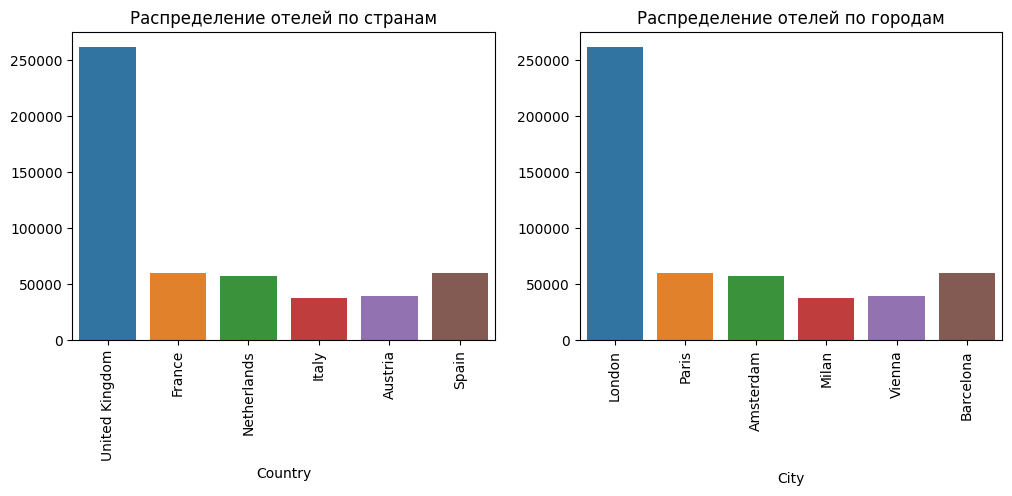

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# распределение по странам
sns.countplot(x='hotel_country', data=data, ax=ax[0])
ax[0].set_title('Распределение отелей по странам')
ax[0].set_xlabel('Country')

# распределение по городам
sns.countplot(x='hotel_city', data=data, ax=ax[1])
ax[1].set_title('Распределение отелей по городам')

# настройка отображения меток и подписей осей
ax[0].set_ylabel('')
ax[0].tick_params(axis='x', rotation=90)

ax[1].set_ylabel('')
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_xlabel('City', labelpad=30)

plt.show();

6 стран, 6 городов с явным преобладанием британских отелей.

Теперь вернемся к признакам координат. Опытным путем можно обнаружить, что заполнение данных признаков медианой дает наилучший результат. Именно этим способом и воспользуемся:

In [22]:
lat_median = data['lat'].median()
lng_median = data['lng'].median()

# заполняем пропуски в признаках медианным значением
data['lat'] = data['lat'].fillna(lat_median)
data['lng'] = data['lng'].fillna(lng_median)

**Примечание:** *я попробовал построчно выявить, в каких городах чаще всего координаты отелей остаются незаполненными. Это оказались Вена, Париж и Барселона. К сожалению, не удалось реализовать заполнение с помощью геокодера и библиотеки Nominatim в связи с отключенным сервером. При этом, работая в Colab, запрос выполняется и реализуется заполнение согласно переданному признаку адреса отеля. Возможно, это связано с тем, что код пишется в локальном Jupyter. Реализация через словарь с переданными в него координатами городов и последующим заполнением через функцию тоже не улучшило финальную метрику. Поэтому я остановился на первоначальном варианте меры центральной тенденции - медиане.*

In [23]:
data.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample,hotel_country,hotel_city
0,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1,United Kingdom,London
1,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1,United Kingdom,London
2,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,1,France,Paris


Итак мы выделили страну и город, в которых находятся отели. В нашем датасете есть также отдельный признак с национальностями ревьюеров. Давайте свяжем эти два признака вместе и создадим столбец - индикатор, где 0 будет сигнализировать о том, что ревьюер является иностранцем, а 1 - соотечественником:

In [24]:
# очистим признак от пробелов
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())

data['foreigner'] = np.where(data['hotel_country'] == data['reviewer_nationality'], 1, 0)

Давайте взглянем, насколько многонационален контингент в представленных отелях:

In [25]:
print(f"Кол-во национальностей: {data['reviewer_nationality'].nunique()}")

Кол-во национальностей: 227


Слишком много категорий. Сузим их до 20 самых популярных, остальные попадут в категорию other:

In [26]:
top_natio = data['reviewer_nationality'].value_counts().nlargest(20).index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top_natio else 'Other')

Теперь закодируем полученные категории при помощи Label Encoder:

In [27]:
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака
data['natio_label'] = lab_enc.fit_transform(data['reviewer_nationality'])

# Сортировка отзывов

Наш датасет также включает в себя пару признаков с отзывами пользователей об отелях - это признаки **negative_review** и **positive_review**. Изучим более детально структуру данных признаков:

In [28]:
data['negative_review'].value_counts().head(10)

No Negative    127890
 Nothing        14295
 Nothing         4236
 nothing         2225
 N A             1037
 None             984
                  849
 N a              509
 Breakfast        407
 Small room       373
Name: negative_review, dtype: int64

In [29]:
data['positive_review'].value_counts().head(10)

No Positive        35946
 Location           9222
 Everything         2284
 location           1677
 Nothing            1243
 The location       1126
 Great location     1047
 Good location       927
 Location            915
 Everything          613
Name: positive_review, dtype: int64

Данные явно нуждаются в очистке. Займемся этим. Избавимся от лишних пробелов и приведем их к единому регистру:

In [30]:
data['negative_review'] = data['negative_review'].apply(lambda x: x.strip().capitalize())
data['positive_review'] = data['positive_review'].apply(lambda x: x.strip().capitalize())

Теперь изучим признак негативных отзывов более подробно:

In [31]:
data['negative_review'].value_counts().head(50)

No negative                       127890
Nothing                            21185
N a                                 1815
None                                1501
                                     849
Nothing really                       656
Small room                           570
All good                             545
Breakfast                            545
No complaints                        523
Location                             502
Nothing at all                       467
Everything                           420
Nothing to dislike                   373
Price                                348
Nil                                  332
Small rooms                          307
Everything was perfect               276
Na                                   272
Can t think of anything              250
Leaving                              244
Absolutely nothing                   242
Everything was great                 222
Expensive                            206
Nothing to compl

Из увиденного можно сделать вывод, что большинство постояльцев отелей оставляют либо нейтральные отзывы, либо положительные только лишь для того, чтобы оставить хоть какой-нибудь комментарий в соответствующем поле. При этом также прослеживаются релевантные отзывы о недостатках отеля и негативном опыте гостя.  

Можно было бы воспользоваться анализом тональности отзыва, чтобы определить степень негатива, однако смешанные внутри признака отзывы будут только затруднять работу модели. Поэтому просто **отсортируем данный признак, преобразовав его в бинарный вид**. Закодируем его следующим образом:  

0 - отзыв нельзя считать негативным  
1 - в отзыве присутствует негативный опыт  

Разберем самые популярные значения внутри признака. Создадим список со стоп-фразами, содержащий фразы с положительный окрасом согласно словам ревьюера:

In [32]:
pos_list = ['No negative', 'Nothing', 'N a', 'None', '', 'Nothing really', 
            'All good', 'No complaints', 'Nothing at all', 'Na', 
            'Everything was perfect', 'Can t think of anything', 
            'Everything was great', 'Nothing to complain about', 'No', 
            'Nothing not to like', 'Everything was good', 'Nothing all good', 
            'Having to leave', 'I liked everything', 'Liked everything', 
            'Nothing everything was perfect', 'Non', 'Nothing it was perfect', 
            'Everything was fine', 'Nothing everything was great', 'All was good', 
            'Not applicable', 'There was nothing i didn t like', 'Nothing comes to mind', 
            'Nil', 'Absolutely nothing', 'Nothing in particular', 'Not a thing', 
            'Nothing to report', 'No complaints at all', 'No negatives', 
            'No thing', 'It was all good', 'There was nothing to dislike', 
            'Nothing i didn t like', 'We liked everything', 'All ok', 'Loved everything', 
            'There was nothing we didn t like', 'Nothing to mention', 'Nothing i can think of', 
            'Nothing to say', 'No problems', 'No comment', 'Nothing to complain', 'No issues', 
            'No bad experience', 'Nothing bad to say', 'There was nothing not to like', 
            'No dislikes', 'Everything was ok']

Выполним соответствующие преобразования:

In [33]:
data['negative_review'] = data['negative_review'].apply(lambda x: 0 if x in pos_list else 1)

Теперь анализу подвергнем признак положительных отзывов:

In [34]:
data['positive_review'].value_counts().head(50)

No positive                      35946
Location                         11945
Everything                        3314
Nothing                           1731
Great location                    1687
The location                      1606
Good location                     1496
Breakfast                          795
Friendly staff                     733
Excellent location                 639
Staff                              553
Location and staff                 452
Location staff                     432
Location location location         345
Location was great                 328
Everything was perfect             316
Good breakfast                     316
Location was good                  312
Comfy bed                          303
Perfect location                   287
The staff                          281
Location is great                  280
Location is good                   256
All                                250
Clean                              237
Every thing              

А вот тут ситуация гораздо лучше. Много релевантных отзывов, соответственно работы по их обработке меньше.

Алгоритм преобразования тот же самый. Единственное отличие - список со стоп-словами, но теперь уже с негативным или нейтральным окрасом:

In [35]:
neg_list = ['No positive', 'Nothing', '']
data['positive_review'] = data['positive_review'].apply(lambda x: 0 if x in neg_list else 1)

Займемся **признаком с тегами**. Избавимся от лишних символов и приведем его в единый формат:

In [36]:
tags_list = data['tags'].apply(lambda x: x[3:-3].split(" ', ' "))
tags = tags_list.explode(ignore_index=True)

Создадим вспомогательный признак - счетчик количества тегов, которые ревьер оставляет в своем отзыве:

In [37]:
data['tags'] = tags_list
data['tags_cnt'] = data['tags'].apply(lambda x: len(x))

Посмотрим на самые популярные у гостей отелей теги:

In [38]:
top_tags = list(tags.value_counts().head(10).index)
top_tags

['Leisure trip',
 'Submitted from a mobile device',
 'Couple',
 'Stayed 1 night',
 'Stayed 2 nights',
 'Solo traveler',
 'Stayed 3 nights',
 'Business trip',
 'Group',
 'Family with young children']

Из увиденного можно сделать вывод, что клиенты останавливаются в отелях по двум самым популярным причинам:  
- с целью отдыха (**тег "leisure trip"**)  

- командировка (**тег "business trip"**)  

Также из отегов можно выделить, путешествуют люди соло или в группе, с детьми или без.  

Закодируем теги, реализуя механизм One-Hot кодирования:

In [39]:
for tag in top_tags:
    one_hot_feature = tag.lower().replace(' ', '_')
    data[one_hot_feature] = data['tags'].apply(lambda x: 1 if tag in x else 0)

На очереди **признак days_since_review**. Проеобразуем его в числовой формат:

In [40]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split()[0]))
data.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,leisure_trip,submitted_from_a_mobile_device,couple,stayed_1_night,stayed_2_nights,solo_traveler,stayed_3_nights,business_trip,group,family_with_young_children
0,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,1,3,1994,1,4,...,1,1,1,0,1,0,0,0,0,0
1,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,1,3,1361,1,2,...,0,0,1,1,0,0,0,1,0,0
2,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,Other,1,6,406,0,0,...,1,1,0,0,0,1,1,0,0,0


Займемся **столбцом с датами**. Как мы помним, изначально тип данных этого признака - object. Преобразуем столбец в формат datetime, а затем извлечем из него год и месяц:

In [41]:
data['review_date'] = pd.to_datetime(data.review_date)

Данные в признаке представлены в формате месяц-день-год. Создадим два новых признака для года и месяца в числовом выражении, в которых был оставлен отзыв. Исходный признак позже удалим:

In [42]:
data['review_month'] = data['review_date'].dt.month
data['review_year'] = data['review_date'].dt.year

Кроме того, дополнительно из признака можно извлечь сезонность отзыва:

In [43]:
def get_season_cat(month):
    """Кодирует признак даты в соответствии с месяцем
    1 - зима
    2 - весна
    3 - лето
    4 - осень
    
    Args:
        int: номер месяца
        
    Returns:
        int: категория сезона согласно кодировке выше
    """  
    if month in [12, 1, 2]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    elif month in [9, 10, 11]:
        return 4
    else:
        return None

In [44]:
# создаем новый признак
data['season'] = data['review_month'].apply(get_season_cat)

# удаляем  исходный столбец с датой
data = data.drop(['review_date'], axis=1)

Итак, у нас остался признак названия отеля:

In [45]:
print(f"Кол-во уникальных отелей в датасете: {data['hotel_name'].nunique()}")

Кол-во уникальных отелей в датасете: 1492


Поскольку каждый отель потенциально является одним из самых значимых признаков для целевой переменной - рейтинга отеля, закодируем его с помощью Label Encoder:

In [46]:
# Кодирование признака
data['hotel_label'] = lab_enc.fit_transform(data['hotel_name'])

Также не забудем про признак страны отеля. Поскольку даже без статистических тестов значимости очевидно, что признаки страны и города отеля сильно коррелируют друг с другом, закодируем для нашей модели только один из них:

In [47]:
col_name = ['hotel_country']
data = pd.get_dummies(data, columns=col_name)

На этом преобразования закончены, удалим все ненужные признаки с типом object из датасета, поскольку модель принимает на вход только числовые признаки:

In [48]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим

object_columns = [col for col in data.columns if data[col].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 36 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   negative_review                             515738 non-null  int64  
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   positive_review                             515738 non-null  int64  
 6   review_total_positive_word_counts           515738 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 8   reviewer_score                              515738 non-null  float64
 9   days_since_review                           515738 non-null  int64  
 

# Корреляционный анализ и оценка значимости признаков

Перед поиском корреляций, созданием и обучением разобъем датафрейм на части, необходимые для обучения и тестирования модели  

**Х** — данные с информацией об отелях,  
**у** — целевая переменная (рейтинги отелей)

In [50]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)  

X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score']

Теперь инициализируем списки непрерывных и категориальных признаков. Они понадобятся нам для дальнейшего анализа:

In [51]:
# непрерывные признаки
num_cols = ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 
            'total_number_of_reviews','review_total_positive_word_counts', 
            'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'tags_cnt', 
            'review_year', 'review_month'
           ]

# категориальные признаки
cat_cols = ['negative_review', 'positive_review', 'foreigner', 'natio_label', 'leisure_trip', 
            'submitted_from_a_mobile_device', 'couple', 'stayed_1_night', 'stayed_2_nights', 
            'solo_traveler', 'stayed_3_nights', 'business_trip', 'group', 'family_with_young_children', 
            'season', 'hotel_label', 'hotel_country_Austria', 'hotel_country_France', 
            'hotel_country_Italy', 'hotel_country_Netherlands', 'hotel_country_Spain', 
            'hotel_country_United Kingdom'
           ]

Построим тепловую матрицу корреляции отдельно для каждого типа признаков. В качестве метода будет использовать корреляцию Спирмена для ненормально распределенных данных:

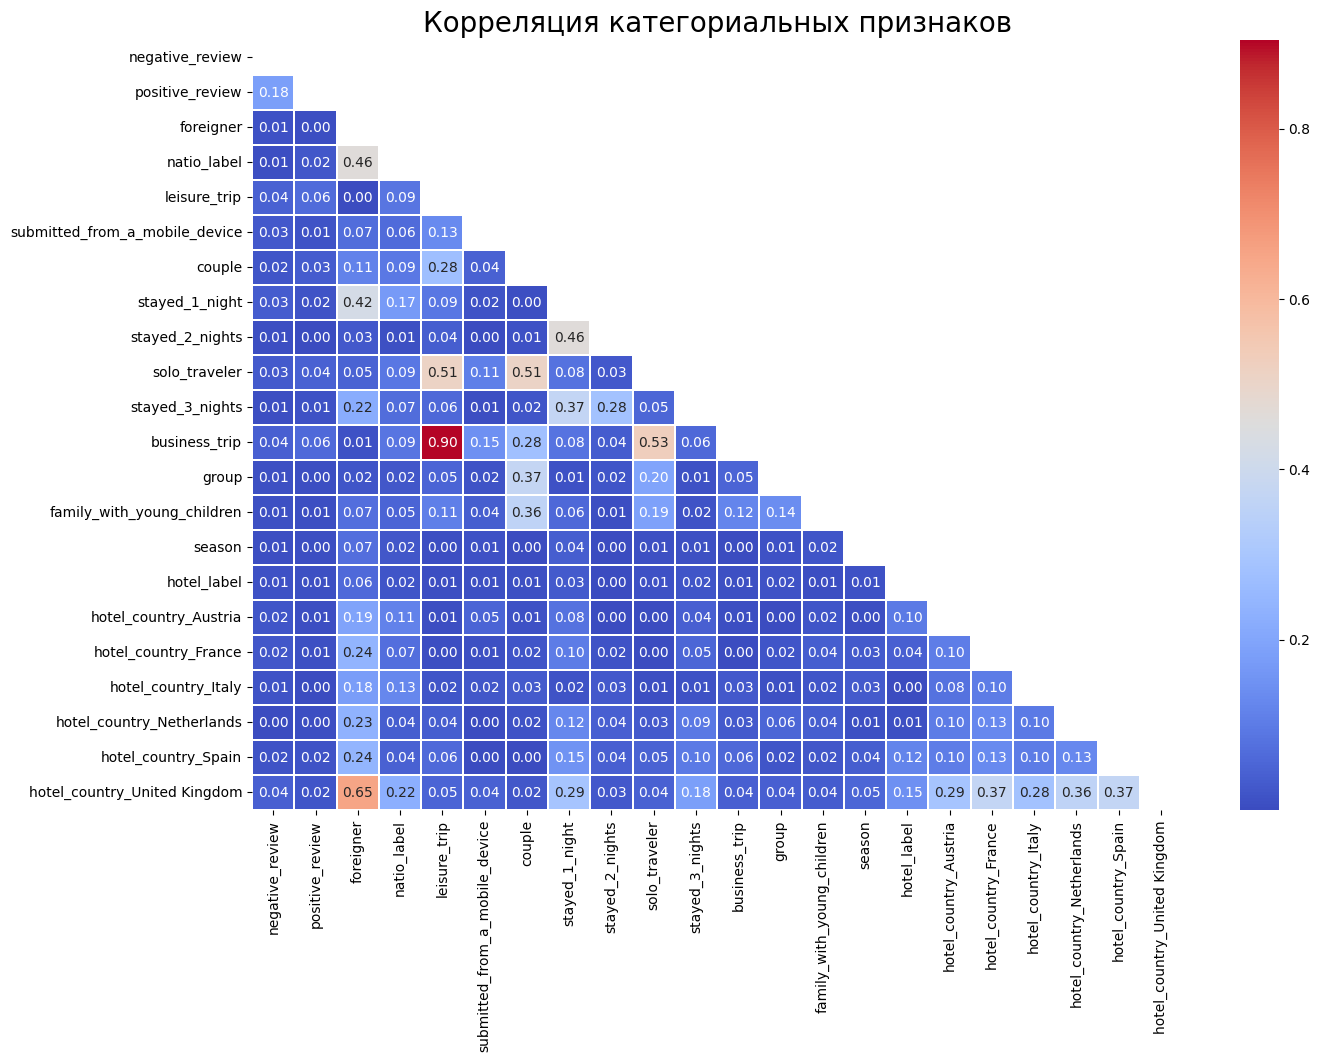

In [52]:
fig, ax = plt.subplots(figsize=(15, 10))

corr_cat_matrix = X[cat_cols].corr(method='spearman').abs()
matrix = np.triu(X[cat_cols].corr(method='spearman'))

sns.heatmap(corr_cat_matrix, 
            annot=True, 
            linewidths=0.3, 
            ax=ax, 
            mask=matrix, 
            cmap='coolwarm',
            fmt='.2f')

ax.set_title('Корреляция категориальных признаков', fontsize=20)

plt.show()

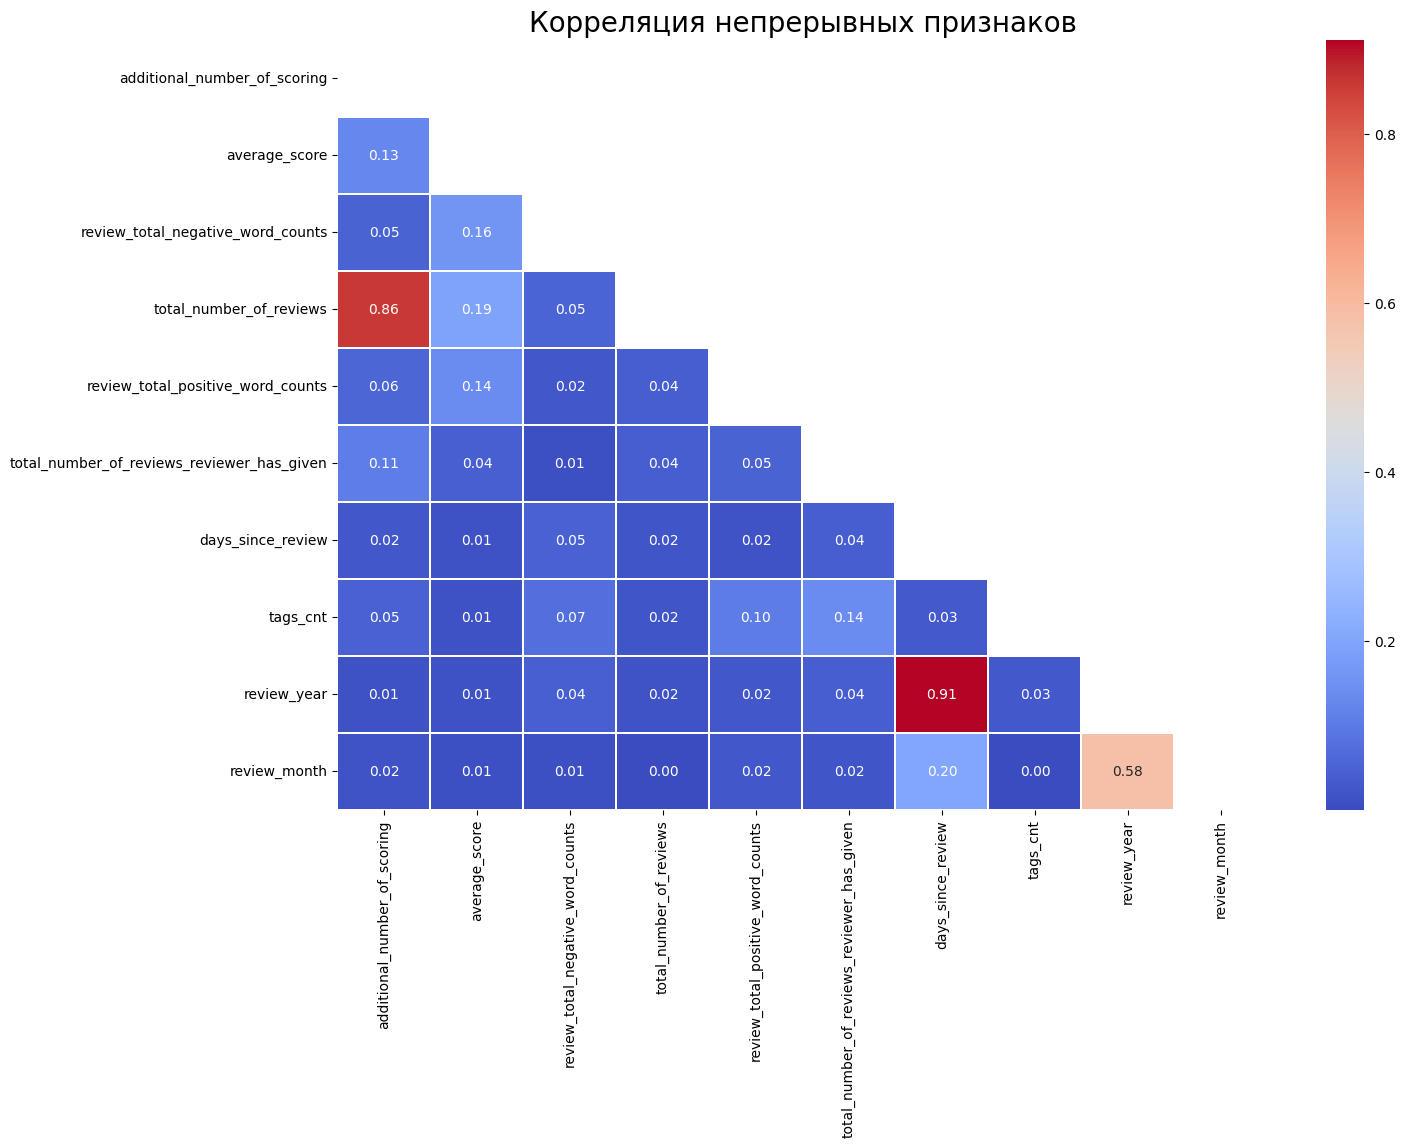

In [53]:
fig, ax = plt.subplots(figsize=(15, 10))

corr_num_matrix = X[num_cols].corr(method='spearman').abs()
matrix = np.triu(X[num_cols].corr(method='spearman'))

sns.heatmap(corr_num_matrix, 
            annot=True, 
            linewidths=0.3, 
            ax=ax, 
            mask=matrix, 
            cmap='coolwarm',
            fmt='.2f')

ax.set_title('Корреляция непрерывных признаков', fontsize=20)

plt.show()

Мы обнаружили 3 пары мультиколлинеарных признаков: **пара тегов business_trip и leisure_trip** среди категориальных, и две пары **review_year - days_since_review** и **additional_number_of_scoring и total_number_of_reviews** среди числовых.  

Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — функцию f_classif из библиотеки sklearn, в основе которой лежит статистический тест ANOVA.

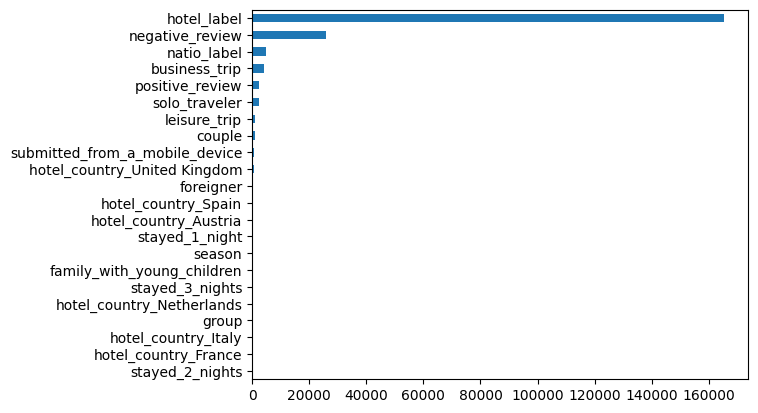

In [54]:
y_int = y.astype('int')

# хи-квадрат, оценка значимости категориальных переменных

imp_cat = pd.Series(chi2(X[cat_cols], y_int)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

По графику важности категориальных признаков мы можем понять, что признак hotel_label важнее, чем negative_review, в определении рейтинга отеля.

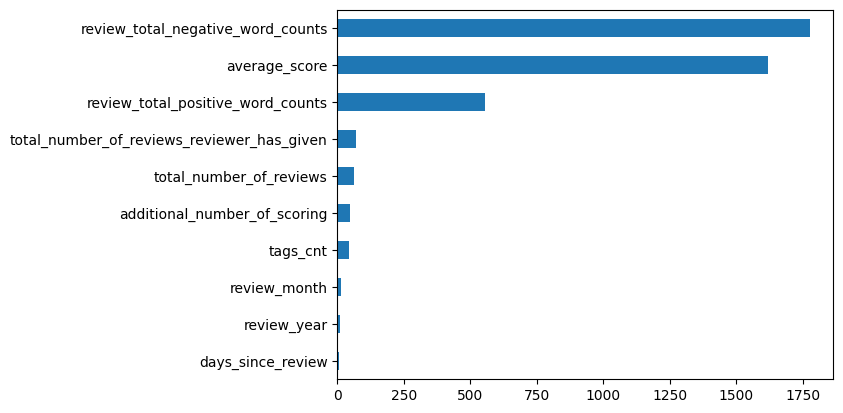

In [55]:
# оценка значимости непрерывных переменных

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

По графику важности непрерывных признаков можно понять, что признак review_total_negative_word_counts важнее, чем review_total_positive_word_counts, в определении рейтинга отеля.

**Примечание**: *следующий этап - отбор признаков. Согласно проведенному выше корреляционному анализу и тесту значимости некоторые признаки менее значимы и незначительно влияют на качество модели. Кроме того, принято удалять мультиколлинеарные признаки с коэффициентом 0.7 и выше. Однако на практике удаление данных признаков значительно ухудшило показатель метрики точности. Модель интерпретировала данные признаки как не менее важные при проектировании, поэтому я отказался от их удаления.* 

# Создание и обучение модели

In [56]:
# выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

# воспользуемся функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [57]:
# проверяем

test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 35), (386803, 35), (386803, 34), (309442, 34), (77361, 34))

In [58]:
# cоздаём модель

model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [59]:
# обучаем модель на тестовом наборе данных

model.fit(X_train, y_train)

# используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# предсказанные значения записываем в переменную y_pred

y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished


In [60]:
# оцениваем точность прогноза

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAPE: 13.307339656787107


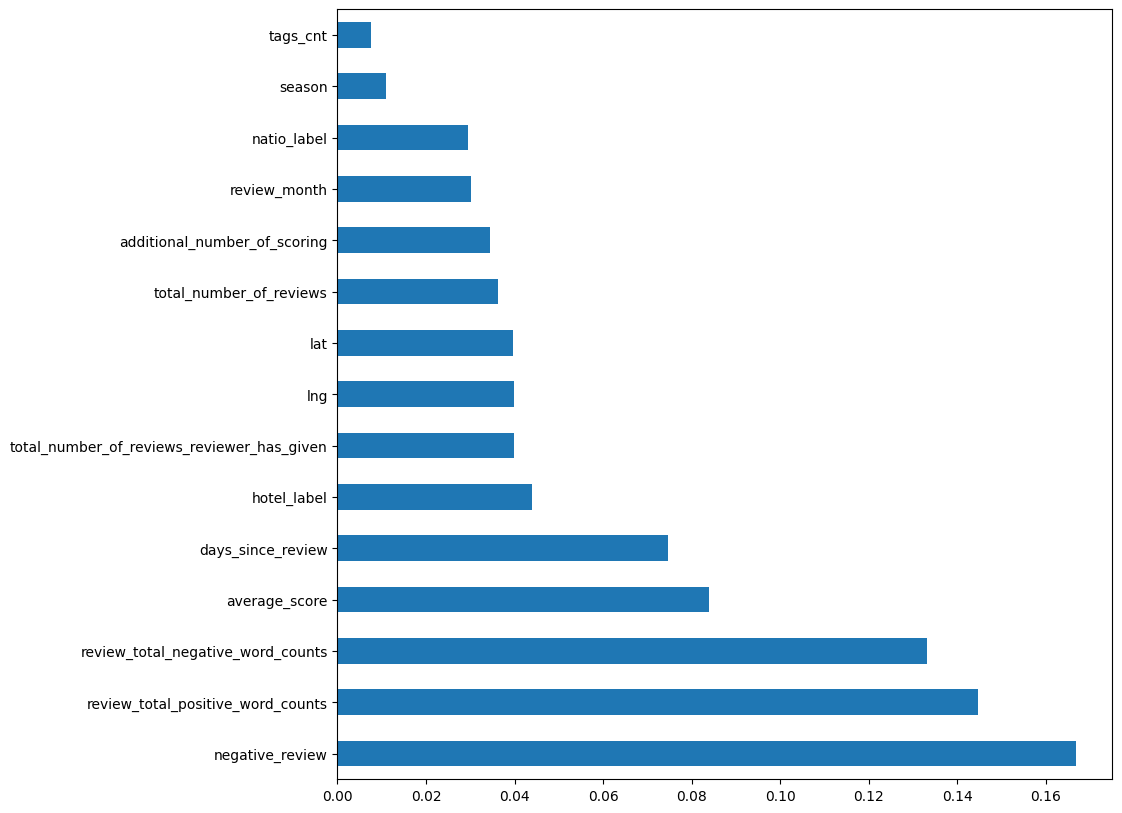

In [61]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

In [62]:
test_data.sample(10)

,additional_number_of_scoring,average_score,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,...,review_month,review_year,season,hotel_label,hotel_country_Austria,hotel_country_France,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_United Kingdom
450270,487,8.8,0,0,1805,1,48,5,0.0,392,...,7,2016,3,291,0,0,0,0,0,1
390241,251,9.0,0,0,2304,1,16,1,0.0,591,...,12,2015,1,560,1,0,0,0,0,0
514347,465,8.9,0,0,2543,1,20,9,0.0,358,...,8,2016,3,1320,0,0,0,0,0,1
485274,120,8.4,1,17,918,1,5,1,0.0,266,...,11,2016,4,346,0,0,0,0,0,1
428817,211,8.9,1,15,2412,1,44,13,0.0,302,...,10,2016,4,752,0,1,0,0,0,0
450079,832,9.1,1,45,4672,1,2,1,0.0,45,...,6,2017,3,1489,0,0,0,0,0,1
448847,229,8.9,1,22,2369,1,34,8,0.0,95,...,4,2017,2,1068,0,0,0,0,1,0
487877,84,8.6,1,28,823,1,7,7,0.0,289,...,10,2016,4,351,0,1,0,0,0,0
427462,130,8.2,1,30,939,0,0,1,0.0,198,...,1,2017,1,1450,1,0,0,0,0,0
406587,145,8.4,0,0,1679,1,9,2,0.0,725,...,8,2015,3,1077,0,0,0,0,1,0


In [63]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [64]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [65]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


In [66]:
predict_submission

array([8.721, 6.598, 7.63 , ..., 7.847, 9.505, 7.495])

In [67]:
list(sample_submission)

['reviewer_score', 'id']

In [68]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.721,488440
1,6.598,274649
2,7.630,374688
3,9.665,404352
4,9.431,451596
5,8.200,302161
6,8.031,317079
7,7.363,13963
8,8.524,159785
9,7.489,195089


# Summary  

Наибольший прирост к точности метрики был достигнут при помощи разбора отзывов и One-Hot Encoding признаков локации, названия и тегов отеля. Напротив, Feature Selection на основе корреляционного анализа и тестов значимости только навредили RandomForestRegressor. Это привело к утере информации, важной для предсказания и снизило объяснимость модели. 

Модель также не показала значительного прироста качества после удаления дубликатов и заполнения координатами. Нормализация также не помогла достичь радикального прироста метрики. Возможно, это особенность ансамблевой модели.

Большой потенциал у признаков тегов и отзывов. Продолжая разбирать их и сосредоточившись на углубленной визуализации, можно получить различные инсайты и много дополнительной потенциально полезной информации для модели.

Во избежание мультиколлинеарности и повышения качества можно попробовать различные варианты препроцессинга данных, таких как L1 и L2-регуляризация, но пока что я не работал с данной методологией. К тому же, цель по метрике MAPE в 13.5% была достигнута.